# ML Forecasting
This notebook explores the perfromance of different algorithims for forecasting stock price (closing).

## Data Download

In [7]:
import yfinance as yf
from datetime import date, timedelta

stock = 'SPY'
years_lookback = 5

df = yf.download(stock, end = date.today(), start = date.today() - timedelta(days = 365 * years_lookback))
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
df.reset_index(inplace = True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2016-10-31,212.550003
1,2016-11-01,211.009995
2,2016-11-02,209.740005
3,2016-11-03,208.779999
4,2016-11-04,208.550003


## Data Exploration

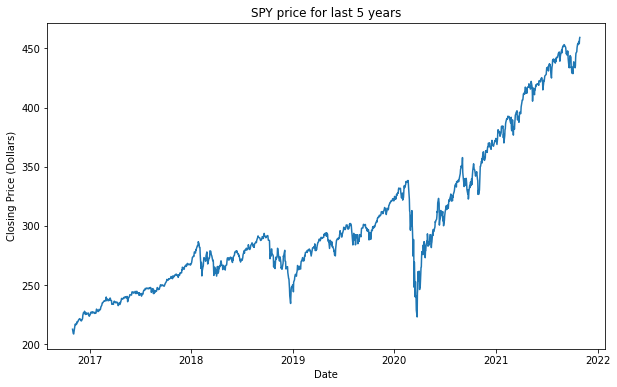

In [8]:
# plot closing price over time
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10,6))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price (Dollars)')
plt.title(f'{stock} price for last {years_lookback} years')
plt.show()

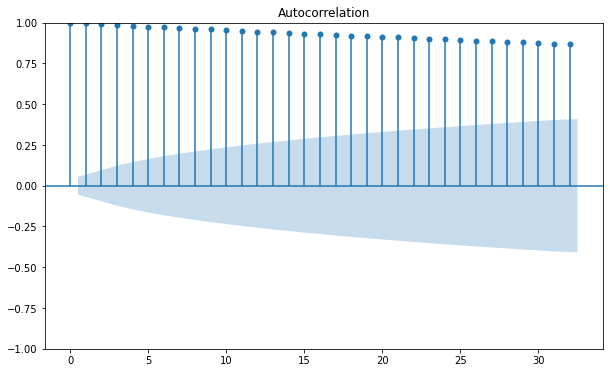

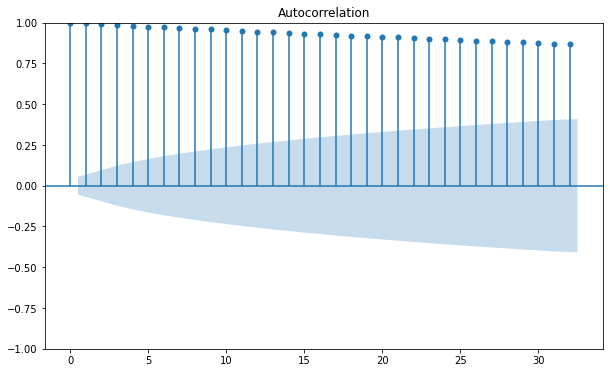

In [9]:
# plot auto correlation
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Close'])

/Users/christian.nickerson/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


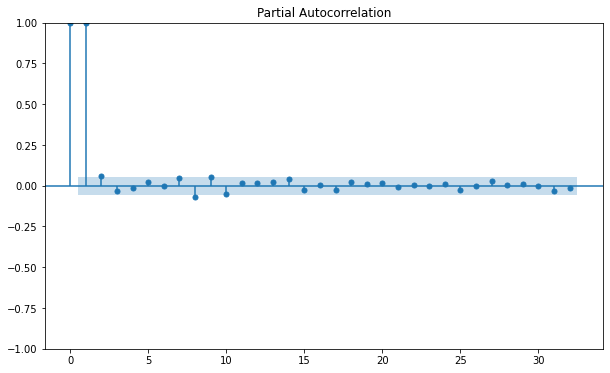

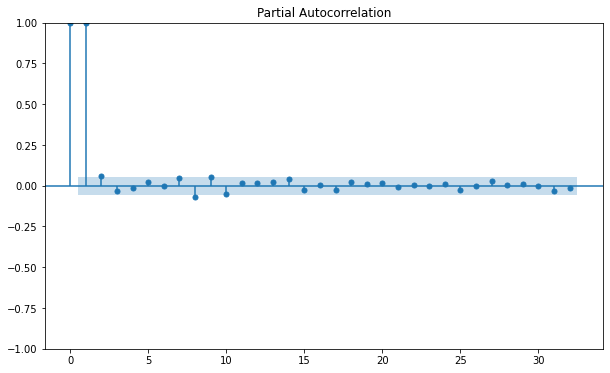

In [10]:
# plot partial auto correlation
import statsmodels.api as sm
plt.rc("figure", figsize=(10,6))
sm.graphics.tsa.plot_pacf(df['Close'])

## Feature Egineering

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

df = df.sort_values('Date')

# date & seasonality features
df['day_of_year'] = df['Date'].dt.dayofyear
df['day_of_month'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek

# closing price for previous n days
for lags in range(1,30):
    df[f'close_lag_{lags}'] = df.Close.shift(lags)

# simple moving average for previous n days
for window in [5,10,30,60,90]:
    df[f'close_sma_{window}'] = df['Close'].rolling(window).mean()

# apply simple exp. smoothing prediction
for alpha in [0.2,0.4,0.6,0.8,None]:
    se = SimpleExpSmoothing(df['Close'])
    se_fitted = se.fit(smoothing_level = alpha)
    df[f'close_ses_{alpha}'] = se_fitted.predict(0)

df.dropna(inplace = True)
df

,Date,Close,day_of_year,day_of_month,day_of_week,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,...,close_sma_5,close_sma_10,close_sma_30,close_sma_60,close_sma_90,close_ses_0.2,close_ses_0.4,close_ses_0.6,close_ses_0.8,close_ses_None
89,2017-03-10,237.690002,69,10,4,236.860001,236.559998,237.000000,237.710007,238.419998,...,237.164001,237.587001,233.700667,230.019668,226.091112,237.033742,237.052218,236.873519,236.824424,236.828987
90,2017-03-13,237.809998,72,13,0,237.690002,236.860001,236.559998,237.000000,237.710007,...,237.184000,237.657001,233.995334,230.187168,226.371778,237.164994,237.307332,237.363409,237.516887,237.570412
91,2017-03-14,236.899994,73,14,1,237.809998,237.690002,236.860001,236.559998,237.000000,...,237.163998,237.700000,234.307000,230.370834,226.659445,237.293995,237.508398,237.631362,237.751375,237.776720
92,2017-03-15,238.949997,74,15,2,236.899994,237.809998,237.690002,236.860001,236.559998,...,237.641998,237.617000,234.687667,230.573168,226.984000,237.215195,237.265036,237.192541,237.070270,237.021767
93,2017-03-16,238.479996,75,16,3,238.949997,236.899994,237.809998,237.690002,236.860001,...,237.965997,237.637999,235.049667,230.797168,227.314000,237.562155,237.939021,238.247015,238.574052,238.682175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2021-10-25,455.549988,298,25,0,453.119995,453.589996,452.410004,450.640015,447.190002,...,453.062000,446.966998,440.831668,443.430500,439.547110,447.588935,451.678114,452.877826,453.146381,453.156385
1255,2021-10-26,455.959991,299,26,1,455.549988,453.119995,453.589996,452.410004,450.640015,...,454.125995,449.200998,441.224667,443.736667,440.003110,449.181146,453.226864,454.481123,455.069266,455.217528
1256,2021-10-27,453.940002,300,27,2,455.959991,455.549988,453.119995,453.589996,452.410004,...,454.431995,451.076999,441.426667,443.949834,440.370666,450.536915,454.320115,455.368444,455.781846,455.856867
1257,2021-10-28,458.320007,301,28,3,453.940002,455.959991,455.549988,453.119995,453.589996,...,455.377997,452.659000,441.798334,444.272167,440.761888,451.217532,454.168070,454.511379,454.308371,454.206246


## Train Test Split

In [13]:
from datetime import timedelta

# create test data on the last 30 days
test = df[df['Date'] >= df['Date'].max() - timedelta(days = 30)]
train = df[df['Date'] < df['Date'].max() - timedelta(days = 30)]

# create x & y data
x_test = test.drop(['Close'], axis = 1)
x_train = train.drop(['Close'], axis = 1)
y_test = test['Close']
y_train = train['Close']

## XGboost Modelling

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
import numpy as np

xgb = XGBRegressor()
xgb_fitted = xgb.fit(x_train, y_train)
y_pred = xgb_fitted.predict(y_test)
rmse = np.sqrt(mse(y_test, y_pred))
print(f'XGBoost RMSE: {rmse}')

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/christian.nickerson/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/christian.nickerson/Documents/python/ml_forecasting/env/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

